## Creating Lo-Fi data for stress growth rheometry
In this notebook, the synthetic generation of Lo-Fi data is introduced based on the given Hi-Fi data. For this case, shear rate (`SR`) and time (`Time`) are the independent variables, while the shear stress (`Stress`) is the dependent variable for which we wish to generate Lo-Fi data. The output of this notebook is `Data_LF_SG.xlsx`, which is the Lo-Fi stress growth data.

### Importing dependencies
Note that the below classses from `sklearn` are called as kernels to generate Lo-Fi data.

In [27]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit
import itertools
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from numpy import genfromtxt
from IPython.display import display, HTML
import matplotlib.font_manager
from matplotlib import rc

### Loading Hi-Fi data to generate Lo-Fi data based on it.
Similar to the steady shear rheometry, it is possible to sample the data and/or exclude experiments, i.e., stress growth curves in this case. Time, shear rate, and shear stress are all log-scaled here. As an example, the $\dot\gamma=1 s^{-1}$ stress growth test is masked here (and also during the MFNN training).

In [28]:
np.set_printoptions(suppress=True)
path = os.getcwd()
files = os.listdir(path)
df = {}
url = 'https://github.com/procf/RhINNs/raw/main/MFNN/StressGrowth/Data_HF_SG.xlsx'
#Uncomment the below line to run locally
# url = pd.ExcelFile('Data_HF_SG.xlsx')

df = pd.read_excel(url, sheet_name=None)
data = [[k,v] for k,v in df.items()] #k is the sheet name, v is the pandas df

i = 0
#set exclusion
# data[i][1] = data[i][1][data[i][1].SR != 0.05]
# data[i][1] = data[i][1][data[i][1].SR != 0.1]
# data[i][1] = data[i][1][data[i][1].SR != 0.5]
data[i][1] = data[i][1][data[i][1].SR != 1]
# data[i][1] = data[i][1][data[i][1].SR != 5]
# data[i][1] = data[i][1][data[i][1].SR != 10]
# data[i][1] = data[i][1][data[i][1].SR != 50]
# data[i][1] = data[i][1][data[i][1].SR != 100]

#Sampling the Hi-Fi data uniformly
data[i][1] = data[i][1].iloc[::5]

SR, Time, Stress = data[i][1]['SR'], data[i][1]['Time'], data[i][1]['Stress']
Time = np.log10(Time)
SR = np.log10(SR)
Stress = np.log10(Stress)

df = np.stack((Time, SR, Stress), axis=1)

### Performing regression on Hi-Fi data by calling `fitter` with a desired kernel, e.g., `LR`
Here, `N_SR` stress vs. time curves between $\dot\gamma=0.05$ and $100 s^{-1}$ are generated.

In [29]:
X = np.stack((Time, SR), axis=1)
y = Stress
lb = [min(X[:,0]), min(X[:,1])]
ub = [max(X[:,0]), max(X[:,1])]
N_SR = 9
SR_f = np.log10([0.05, 0.1, 0.5, 1. , 5., 10., 50., 100.])
N_Time = 10*int(len(X)/len(SR_f))

Time_f=np.linspace(lb[0], ub[0], N_Time)
X_f=np.array(list(itertools.product(Time_f, SR_f)))
print(len(X_f)/len(X))

def fitter(mode, X, X_pred):
    if mode == 'LR':
        poly = PolynomialFeatures(degree=1)
        X_poly = poly.fit_transform(X)
        model = LinearRegression()
        model.fit(X_poly, y)
        X_pred = poly.fit_transform(X_pred)
        return model.predict(X_pred)
    elif mode == 'EN':
        model = ElasticNet(alpha=0.1, l1_ratio=0.5)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'RF':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'SVR':
        model = SVR(kernel='rbf', C=2, gamma=5)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'GB':
        model = GradientBoostingRegressor(n_estimators=100,
                                          learning_rate=0.1, max_depth=2, random_state=0)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'kNN':
        model = model = KNeighborsRegressor(n_neighbors=2)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'BR':
        model = BayesianRidge()
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'MLP':
        model = MLPRegressor(hidden_layer_sizes=(20, 20, 20),
                             activation='tanh', max_iter=50000,
                            random_state=2, solver='lbfgs')
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'Ridge':
        model = Ridge(alpha=1.0)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'Lasso':
        model = Lasso(alpha=0.1)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'DT':
        model = DecisionTreeRegressor(max_depth=5)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'AB':
        base_model = DecisionTreeRegressor(max_depth=3)
        model = AdaBoostRegressor(base_model, n_estimators=50, learning_rate=0.1)
        model.fit(X, y)
        return model.predict(X_pred)
y_f = fitter('LR', X, X_f) #LR, EN, RF, SVR, GB, kNN, BR

9.824561403508772


### Visualizing the generated Lo-Fi data against the Hi-Fi data

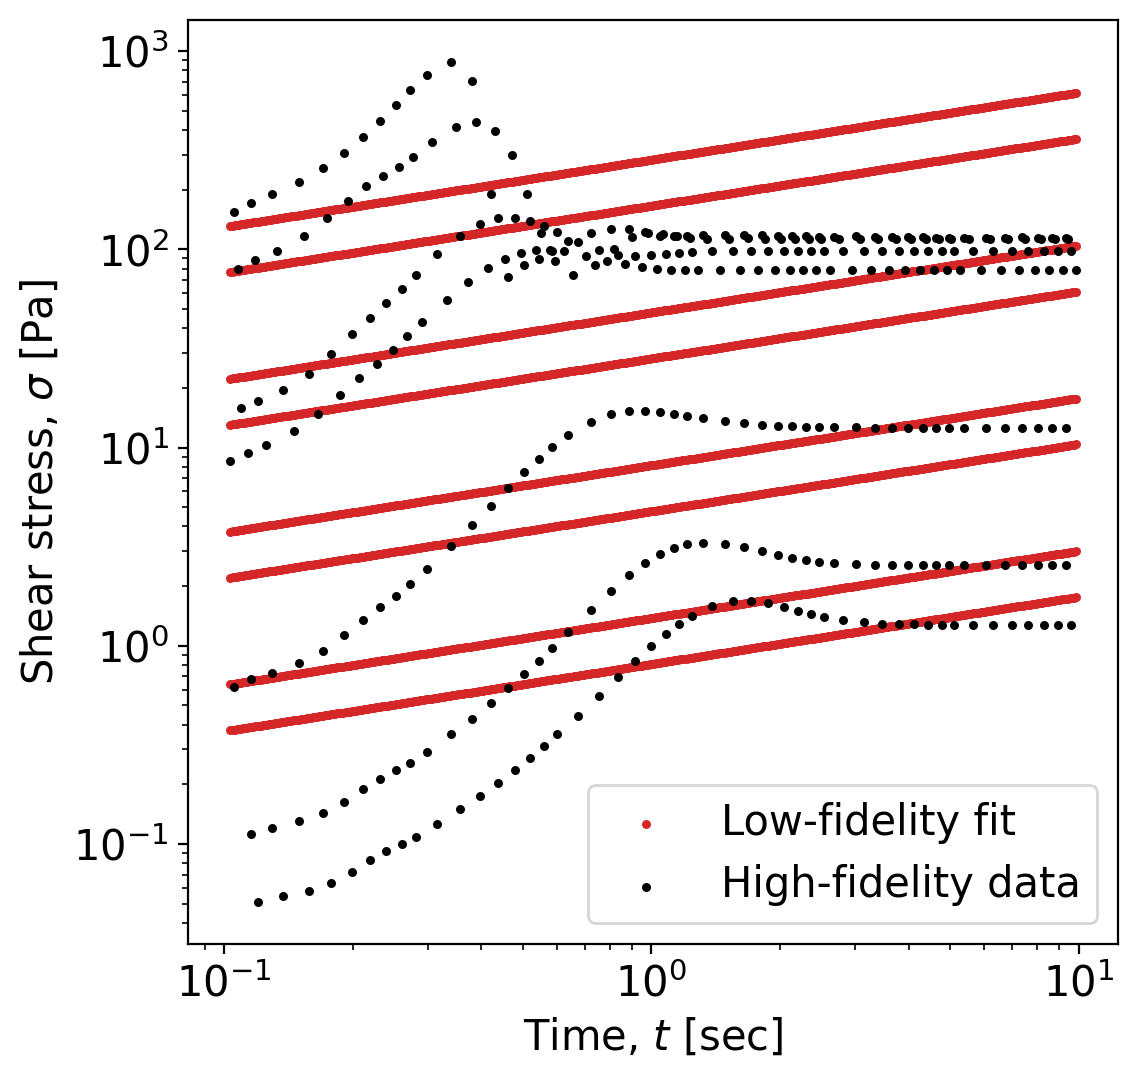

In [30]:
plt.figure(figsize=(6,6),dpi=200)
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=15)  # fontsize of the figure title
plt.scatter(10**X_f[:,0], 10**y_f, label='Low-fidelity fit', color='tab:red', s=5)
plt.scatter(10**X[:,0], 10**y, label='High-fidelity data', color='k', s=5)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Shear stress, $\sigma$ [Pa]')
plt.xlabel('Time, $t$ [sec]')
plt.show()

### Exporting the Lo-Fi data to `Data_LF_SG.xlsx` (optional)
You may store this excel file locally, or use Google Colab, which has access to `Data_LF_SG.xlsx` on GitHub.

In [31]:
Time_LF, SR_LF, Stress_LF = 10**X_f[:,0], 10**X_f[:,1], 10**y_f
df_LF_raw = np.stack((Time_LF, SR_LF, Stress_LF), axis=1)
df_LF = pd.DataFrame(df_LF_raw, columns = ['Time','ShearRate','Stress'])
df_LF.to_excel("Data_LF_SG.xlsx", index=False)